In [ ]:
# segment-anything-2-real-time/webcam_test.mp4


In [3]:
!pip install opencv-python


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [7]:
import torch
import cv2
from sam2.build_sam import build_sam2_camera_predictor
from IPython.display import display, clear_output, Image
import tempfile


checkpoint = "./checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"
predictor = build_sam2_camera_predictor(model_cfg, checkpoint)

cap = cv2.VideoCapture("segment-anything-2-real-time/webcam_test.mp4")

if_init = False

with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        width, height = frame.shape[:2][::-1]

        if not if_init:
            predictor.load_first_frame(frame)
            if_init = True
            _, out_obj_ids, out_mask_logits = predictor.add_new_prompt("follow the face")

        else:
            out_obj_ids, out_mask_logits = predictor.track(frame)
            
        # Process output mask (e.g., overlay it on the frame)
        mask = (out_mask_logits > 0).cpu().numpy().astype("uint8") * 255  # Binarize the mask
        mask = cv2.resize(mask, (width, height))  # Resize mask to frame dimensions
        mask_colored = cv2.applyColorMap(mask, cv2.COLORMAP_JET)  # Optional: colorize the mask

        # Overlay the mask on the frame
        overlayed_frame = cv2.addWeighted(frame, 0.7, mask_colored, 0.3, 0)

        # Save the frame to a temporary file
        with tempfile.NamedTemporaryFile(suffix=".jpg") as tmp_file:
            cv2.imwrite(tmp_file.name, overlayed_frame)
            clear_output(wait=True)  # Clear previous output
            display(Image(filename=tmp_file.name))  # Display updated frame in the notebook


# Release resources
cap.release()
cv2.destroyAllWindows()

In [23]:
import torch
import cv2
from sam2.build_sam import build_sam2_camera_predictor
import matplotlib.pyplot as plt
from IPython.display import clear_output

checkpoint = "./checkpoints/sam2_hiera_tiny.pt"
model_cfg = "sam2_hiera_t.yaml"
predictor = build_sam2_camera_predictor(model_cfg, checkpoint)

# Load video file
cap = cv2.VideoCapture("webcam_test.mp4")

if_init = False

with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        height, width = frame.shape[:2]

        if not if_init:
            predictor.load_first_frame(frame)
            if_init = True
            obj_id = 1  # Replace with the appropriate object ID if needed
            frame_idx = 0
            bbox = [590, 310, 690, 410] # Replace with the appropriate bounding box coordinates [x1, y1, x2, y2]
            _, out_obj_ids, out_mask_logits = predictor.add_new_prompt(obj_id=obj_id, bbox=bbox, frame_idx=frame_idx)

        else:
            out_obj_ids, out_mask_logits = predictor.track(frame)
            
        # Process output mask (e.g., overlay it on the frame)
        # Extract the 2D mask from out_mask_logits
        if out_mask_logits.shape[0] > 0:
            mask = (out_mask_logits[0, 0] > 0).cpu().numpy().astype("uint8") * 255  # Binarize the mask
        else:
            mask = np.zeros((height, width), dtype="uint8")

        print("Mask shape:", mask.shape)
        print("Frame width and height:", width, height)

        mask = cv2.resize(mask, (width, height))  # Resize mask to frame dimensions
        mask_colored = cv2.applyColorMap(mask, cv2.COLORMAP_JET)  # Optional: colorize the mask

        # Overlay the mask on the frame
        overlayed_frame = cv2.addWeighted(frame, 0.7, mask_colored, 0.3, 0)

        # Convert from BGR (OpenCV format) to RGB for matplotlib display
        overlayed_frame_rgb = cv2.cvtColor(overlayed_frame, cv2.COLOR_BGR2RGB)

        # Display the frame using matplotlib
        clear_output(wait=True)  # Clear previous output
        plt.imshow(overlayed_frame_rgb)
        plt.axis('off')  # Hide axis for a cleaner display
        plt.show()

# Release resources
cap.release()



KeyboardInterrupt



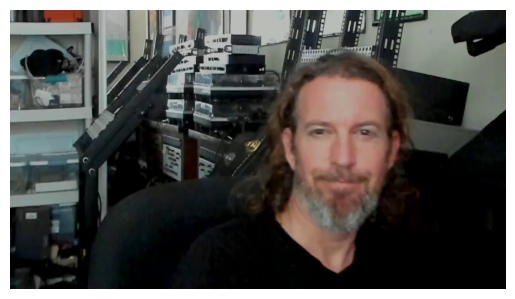

In [10]:
import cv2
import matplotlib.pyplot as plt

# Load video file
cap = cv2.VideoCapture("webcam_test.mp4")

ret, frame = cap.read()
if ret:
    # Convert from BGR to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(frame_rgb)
    plt.axis('off')  # Hide axis
    plt.show()
else:
    print("Failed to capture frame.")

cap.release()


In [ ]:
import torch
import cv2
from sam2.build_sam import build_sam2_camera_predictor
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np

checkpoint = "./checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"
predictor = build_sam2_camera_predictor(model_cfg, checkpoint)

# Load video file
cap = cv2.VideoCapture("webcam_test.mp4")

if_init = False

with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        height, width = frame.shape[:2]

        if not if_init:
            predictor.load_first_frame(frame)
            if_init = True
            obj_id = 1  # Example object ID
            frame_idx = 0

            # Define the point prompt
            point = [int(width * 1 / 5), int(height / 2)]  # One-third from the right, centered vertically
            points = [point]
            labels = [1]  # Positive prompt

            _, out_obj_ids, out_mask_logits = predictor.add_new_prompt(frame_idx, obj_id, points=points, labels=labels)

        else:
            out_obj_ids, out_mask_logits = predictor.track(frame)
            
        # Process output mask (e.g., overlay it on the frame)
        if out_mask_logits.shape[0] > 0:
            mask = (out_mask_logits[0, 0] > 0).cpu().numpy().astype("uint8") * 255
        else:
            mask = np.zeros((height, width), dtype="uint8")

        mask = cv2.resize(mask, (width, height))  # Resize mask to frame dimensions
        mask_colored = cv2.applyColorMap(mask, cv2.COLORMAP_JET)  # Optional: colorize the mask

        # Overlay the mask on the frame
        overlayed_frame = cv2.addWeighted(frame, 0.7, mask_colored, 0.3, 0)

        # Convert from BGR (OpenCV format) to RGB for matplotlib display
        overlayed_frame_rgb = cv2.cvtColor(overlayed_frame, cv2.COLOR_BGR2RGB)

        # Display the frame using matplotlib
        clear_output(wait=True)  # Clear previous output
        plt.imshow(overlayed_frame_rgb)
        plt.axis('off')  # Hide axis for a cleaner display
        plt.show()

# Release resources
cap.release()


In [40]:
import torch
import cv2
from sam2.build_sam import build_sam2_camera_predictor
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np

checkpoint = "./checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"
predictor = build_sam2_camera_predictor(model_cfg, checkpoint)

# Load video file
cap = cv2.VideoCapture("webcam_test.mp4")

if_init = False

with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        height, width = frame.shape[:2]

        if not if_init:
            predictor.load_first_frame(frame)
            if_init = True
            obj_id = 1  # Example object ID
            frame_idx = 0

            # Define the point prompt
            point = [int(width * 2 / 3), int(height / 2)]  # One-third from the right, centered vertically
            points = [point]
            labels = [1]  # Positive prompt

            # Display the point on the frame as a visual confirmation
            cv2.circle(frame, tuple(point), radius=5, color=(0, 255, 0), thickness=-1)  # Green dot

            _, out_obj_ids, out_mask_logits = predictor.add_new_prompt(frame_idx, obj_id, points=points, labels=labels)

        else:
            out_obj_ids, out_mask_logits = predictor.track(frame)
            
        # Process output mask (e.g., overlay it on the frame)
        if out_mask_logits.shape[0] > 0:
            mask = (out_mask_logits[0, 0] > 0).cpu().numpy().astype("uint8") * 255
        else:
            mask = np.zeros((height, width), dtype="uint8")
        
        # Option 1: Invert the mask to highlight only the object
        mask = cv2.bitwise_not(mask)
        
        mask = cv2.resize(mask, (width, height))  # Resize mask to frame dimensions
        mask_colored = cv2.applyColorMap(mask, cv2.COLORMAP_JET)  # Optional: colorize the mask
        # Display the point on the frame as a visual confirmation
        cv2.circle(frame, tuple(point), radius=5, color=(0, 255, 0), thickness=-1)  # Green dot

        # Overlay the mask on the frame
        overlayed_frame = cv2.addWeighted(frame, 0.7, mask_colored, 0.3, 0)

        # Convert from BGR (OpenCV format) to RGB for matplotlib display
        overlayed_frame_rgb = cv2.cvtColor(overlayed_frame, cv2.COLOR_BGR2RGB)

        # Display the frame using matplotlib
        clear_output(wait=True)  # Clear previous output
        plt.imshow(overlayed_frame_rgb)
        plt.axis('off')  # Hide axis for a cleaner display
        plt.show()

# Release resources
cap.release()


KeyboardInterrupt: 

In [34]:
cap.release()